- 데이터 준비

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread             # 이미지를 읽어 들인다
from skimage.transform import resize      # 이미지의 크기를 변경할 수 있다

In [ ]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj1/40/'

imgR, imgC, channel = 24, 24, 3 #이미지 크기가 24X24인 동일 크기, 각 이미지가 R,G,B가지므로 채널 수 3
images = []

for i in range(40):
    file = url + 'img{0:02d}.jpg'.format(i+1)    # 이미지 파일 이름을 만든다
    img = imread(file)                           # 이미지를 읽는다
    img = resize(img, (imgR,imgC, channel))      # 이미지의 크기를 변경한다
    images.append(img)                           # img에 담는다

<Figure size 432x288 with 0 Axes>

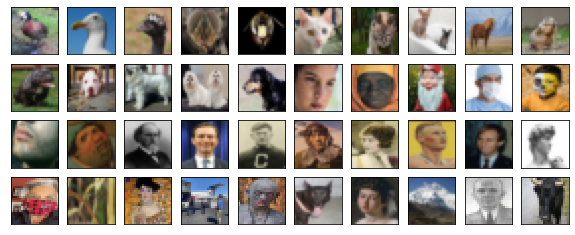

In [ ]:
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

plot_images(4, 10, images)

- 훈련용 테스트용 데이터 나누기

In [ ]:
X = np.array(images[:30]) #처음 30장 훈련용 데이터
X_test =np.array(images[30:]) #나머지 10장 검즘용 데이터 

<Figure size 432x288 with 0 Axes>

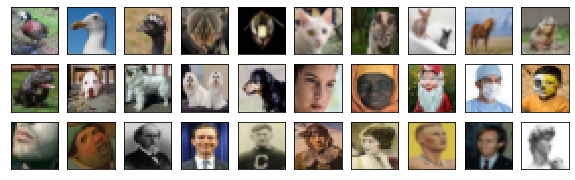

<Figure size 432x288 with 0 Axes>

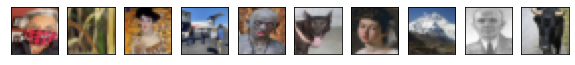

In [ ]:
plot_images(3, 10, X)
plot_images(1, 10, X_test)

- 입력 데이터 준비를 위해 잡음 섞인 이미지 만들기

In [ ]:
X_noisy = X + np.random.randn(len(X), imgR, imgC, channel)*0.1 #잡음 섞인 이미지 만들기 
X_noisy = np.clip(X_noisy, 0, 1) #이미지의 픽셀 값이 0보다 작거나 1보다 큰 경우를 방지하여 이미지가 적절하게 표현
X_test_noisy =  X_test + np.random.randn(len(X_test), imgR, imgC, channel)*0.1
X_test_noisy = np.clip(X_test_noisy, 0, 1)

<Figure size 432x288 with 0 Axes>

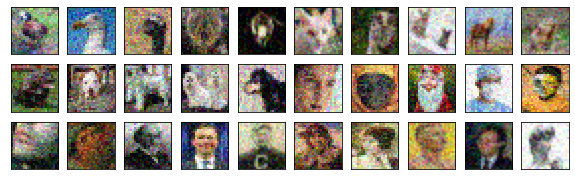

<Figure size 432x288 with 0 Axes>

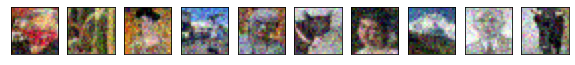

In [ ]:
#잡음이 추가된 이미지 확인
plot_images(3, 10, X_noisy)
plot_images(1, 10, X_test_noisy)

- 분류기 입출력 데이터 형식 바꾸기

<Figure size 432x288 with 0 Axes>

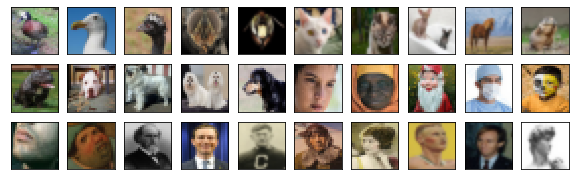

<Figure size 432x288 with 0 Axes>

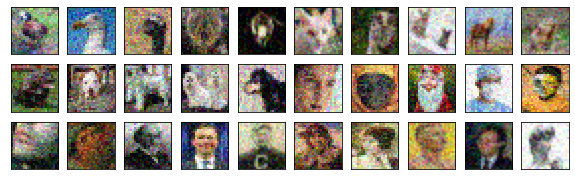

In [ ]:
X_noisy_flat =X_noisy.reshape(-1, imgR*imgC*channel)  #X_noisy 배열을 2차원 배열로 변환한 것,-1은 해당 차원의 크기를 유지하고 나머지 차원을 해당 크기에 맞게 자동으로 조절
X_flat = np.array(X.reshape(-1, imgR*imgC*channel) * 255, dtype=np.uint) #이미지 하나당 가지는 픽셀 수를 나타내며, 각 픽셀이 가진 0에서 1사이의 부동소수점 값을 0~255 사이 정수로

plot_images(3, 10, X_flat.reshape(-1, imgR, imgC, channel))
plot_images(3, 10, X_noisy_flat.reshape(-1, imgR, imgC, channel))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_noisy_flat, X_flat) # 입력데이터 , 출력데이터(라벨링)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<Figure size 432x288 with 0 Axes>

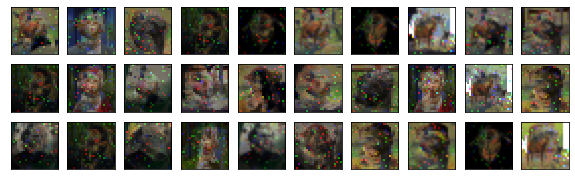

In [ ]:
denoised_result = knn.predict(X_noisy_flat)
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel)
plot_images(3, 10, denoised_result)
# 고작 30개의 이미지로 훈련해서는 제대로 된 픽셀 예측이 어렵다

- 데이터 증강하여 훈련 효과 높이기

In [ ]:
n_augmentation = 100 #데이터를 증강해서 덧붙이는 횟수
X_noisy_aug = X + np.random.rand(len(X), imgR, imgC, channel) * 0.2
y_label = np.array(X * 255, dtype = np.uint) #배열을 0~255 범위의 부호 없는 8비트 정수형으로 변환
y = y_label

print(X_noisy.shape)
for i in range(n_augmentation):  # 반복해서 총 이미지가 300장에서 3030장으로 늘어남
    noisy_data = X + np.random.randn(len(X), imgR, imgC, channel) * 0.2
    X_noisy_aug = np.append(X_noisy_aug, noisy_data, axis=0) #입력데이터에 append하면서 늘려주기
    y = np.append(y, y_label, axis = 0) # 라벨링값에 append하면서 늘려주기

X_noisy_aug = np.clip(X_noisy_aug, 0, 1) #배열을 0과 1 사이의 값으로 클리핑하여 이미지를 적절하게 표현
X_noisy_aug.shape, y.shape

(30, 24, 24, 3)


((3030, 24, 24, 3), (3030, 24, 24, 3))

<Figure size 432x288 with 0 Axes>

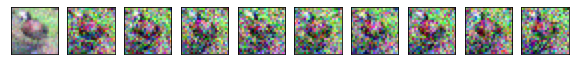

In [ ]:
plot_images(1, 10, X_noisy_aug[0:300:30])

In [ ]:
X_noisy_aug_flat = X_noisy_aug.reshape(-1, imgR*imgC*channel)
y_flat = y.reshape(-1, imgR*imgC*channel)

knn.fit(X_noisy_aug_flat, y_flat) #증강한 데이터 학습 
#knn.fit(X_train_noisy_flat, X_train_flat)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<Figure size 432x288 with 0 Axes>

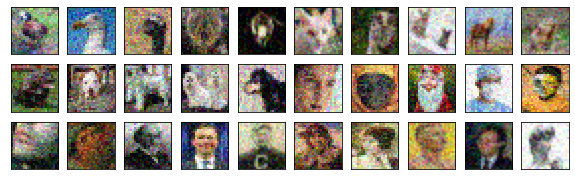

<Figure size 432x288 with 0 Axes>

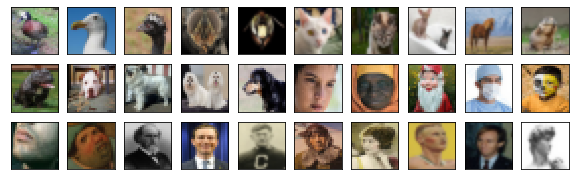

In [ ]:
denoised_result = knn.predict(X_noisy_flat) #학습이 잘되었는지 분류기를 통해 예측
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel) #이미지 출력위해 다시 형태 맞춰주기 


plot_images(3, 10, X_noisy) #잡음 넣은 이미지
plot_images(3, 10, denoised_result) # 예측이 잘되었는지 확인하기위한 이미지


<Figure size 432x288 with 0 Axes>

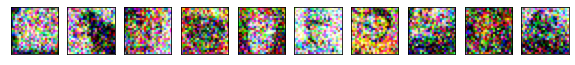

<Figure size 432x288 with 0 Axes>

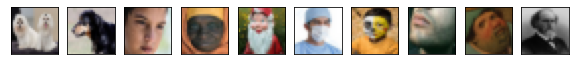

In [ ]:
#강한 잡음에도 예측 잘함 
rndidx = np.random.randint(0, 20)
data = X[rndidx:rndidx+10] + np.random.randn(10, imgR, imgC, channel)*0.4 #0.4로 더 강한 잡음 
data = np.clip(data, 0, 1)
data_flat = data.reshape(-1, imgR*imgC*channel)

denoised = knn.predict(data_flat)
denoised = denoised.reshape(-1, imgR, imgC, channel)
denoised = np.clip(denoised, 0, 255)

plot_images(1, 10, data)
plot_images(1, 10, denoised)

<Figure size 432x288 with 0 Axes>

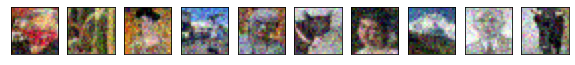

<Figure size 432x288 with 0 Axes>

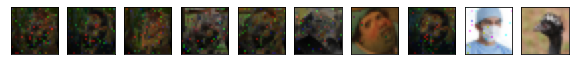

In [ ]:
#모델의 일반화 능력이 높지않다
denoised = knn.predict(X_test_noisy.reshape(-1, imgR*imgC*channel)) #X_test_noisy를 이용해서 검증 
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised)

- 데이터 증강으로 일반화 능력 높이기

In [ ]:
#이번에는 출력 이미지를 다양한 방법으로 왜곡 시켜서 정잡 레이블을 증가 
### Label Augmentation ####
#회전, 확대축소, 기울이기, 상하좌우 반전 등 
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=360, 
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)


In [ ]:
y_aug = X.reshape(-1, imgR, imgC, channel) #깨끗한 이미지를 담고있는 X를 이용해서 처음 증강된 레이블 데이터 담고 있을 y_aug만듦
it = image_generator.flow(y_aug)
nData = y_aug.shape[0] #이미지가 몇개인지 저장

In [ ]:

X_aug = y_aug + np.random.randn(nData, imgR, imgC, channel)*0.1 #y_aug에 잡음을 섞어서 입력 데이터 만들기 

n_augmentation = 500
for _ in range(n_augmentation):
    new_y = it.next() #이미지 생성기의 반복자가 가진 next()호출해 새로운 이미지를 만듦 이것이 새로운 레이블 new_y
    new_X = new_y + np.random.randn(nData, imgR, imgC, channel)*0.1 #새로운 입력 nes_x는 여기에 잡음을 추가
    y_aug = np.append(y_aug, new_y, axis=0) #레이블    
    X_aug = np.append(X_aug, new_X, axis=0) #입력데이터


y_aug = np.array(y_aug * 255, dtype = np.uint)
y_aug = y_aug.reshape(-1, imgR, imgC, channel)
X_aug = X_aug.reshape(-1, imgR, imgC, channel)

In [ ]:
y_aug = np.clip(y_aug, 0,255) #출력은 0에서 255
X_aug = np.clip(X_aug, 0, 1) #입력은 0에서 1

<Figure size 432x288 with 0 Axes>

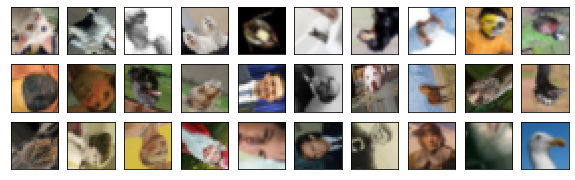

<Figure size 432x288 with 0 Axes>

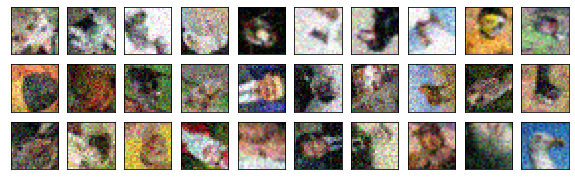

In [ ]:
plot_images(3, 10, y_aug[30:])
plot_images(3, 10, X_aug[30:])

In [ ]:
X_aug_flat = X_aug.reshape(-1, imgR*imgC*channel)
y_aug_flat = y_aug.reshape(-1, imgR*imgC*channel)
knn.fit(X_aug_flat, y_aug_flat)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<Figure size 432x288 with 0 Axes>

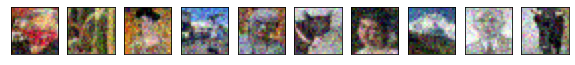

<Figure size 432x288 with 0 Axes>

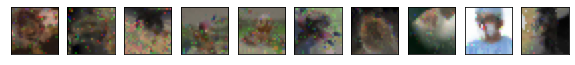

In [ ]:
#완전히 새로운 데이터에 대해서는 답을 잘 찾지 못함
denoised = knn.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised)

<Figure size 432x288 with 0 Axes>

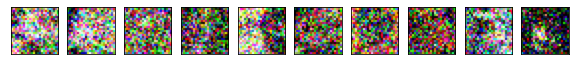

<Figure size 432x288 with 0 Axes>

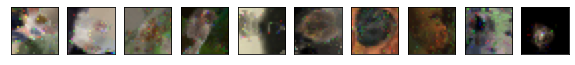

In [ ]:
# 강한 잡음을 추가한 이미지는 유사한 것들이기 때문에 답을 잘찾음 
images = it.next()
testX = images + np.random.randn(nData, imgR, imgC, channel)*0.4
testX = np.clip(testX, 0, 1)
denoised = knn.predict(testX.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, testX)
plot_images(1, 10, denoised)